In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

In [57]:
import matplotlib as mpl

In [9]:
import numpy as np
import scipy.constants as cs
import scipy.special as ss
from matplotlib import pyplot as plt
from matplotlib import cm
from qkit.qkit.gui.notebook.Progress_Bar import Progress_Bar as pb
from scipy.integrate import dblquad
from scipy import integrate

In [3]:
from qutip import *

In [1]:
import time
from mpl_toolkits.mplot3d import Axes3D

In [131]:
mu_0 = cs.mu_0
mu_B = cs.physical_constants['Bohr magneton'][0]   #Bohr magneton in SI units
k_b = cs.k

In [132]:
hbar = cs.hbar
e=cs.e

In [133]:


def compute(N, wc, wa, glist, use_rwa):

    # Pre-compute operators for the hamiltonian
    a  = tensor(destroy(N), qeye(2))
    sm = tensor(qeye(N), destroy(2))
    nc = a.dag() * a
    na = sm.dag() * sm
        
    idx = 0
    na_expt = np.zeros(shape(glist))
    nc_expt = np.zeros(shape(glist))
    for g in glist:

        # recalculate the hamiltonian for each value of g
        if use_rwa: 
            H = wc * nc + wa * na + g * (a.dag() * sm + a * sm.dag())
        else:
            H = wc * nc + wa * na + g * (a.dag() + a) * (sm + sm.dag())

        # find the groundstate of the composite system
        evals, ekets = H.eigenstates()
        psi_gnd = ekets[0]
        na_expt[idx] = expect(na, psi_gnd)
        nc_expt[idx] = expect(nc, psi_gnd)

        idx += 1

    return nc_expt, na_expt, ket2dm(psi_gnd)
    
#
# set up the calculation
#
wc = 1.0 * 2 * np.pi   # cavity frequency
wa = 1.0 * 2 * np.pi   # atom frequency
N = 20              # number of cavity fock states
use_rwa = False     # Set to True to see that non-RWA is necessary in this regime

glist = np.linspace(0, 2.5, 50) * 2 * np.pi # coupling strength vector

start_time = time.time()
nc, na, rhoss_final = compute(N, wc, wa, glist, use_rwa)
print('time elapsed = ' + str(time.time() - start_time)) 



time elapsed = 0.638999938965


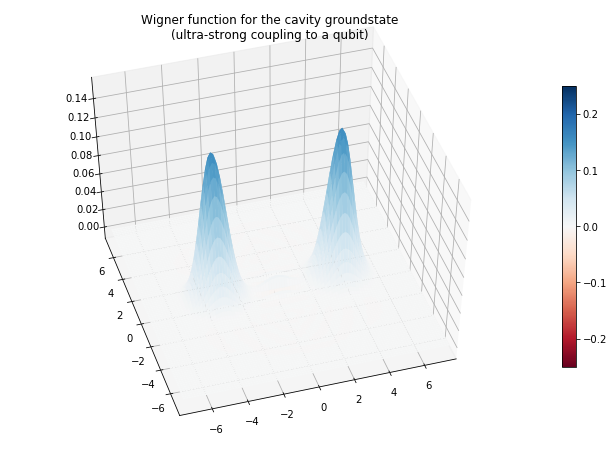

In [134]:


#
# plot the cavity wigner function for the cavity state (final coupling strenght)
#
fig = plt.figure(2, figsize=(9, 6))
rho_cavity = ptrace(rhoss_final, 0)
xvec = np.linspace(-7.5,7.5,100)
X,Y = np.meshgrid(xvec, xvec)
W = wigner(rho_cavity, xvec, xvec)
ax = Axes3D(fig, azim=-107, elev=49)
surf=ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=plt.cm.RdBu, alpha=1.0, linewidth=0.05, 
                     vmax=0.25, vmin=-0.25)
ax.set_xlim3d(-7.5, 7.5)
ax.set_ylim3d(-7.5, 7.5)
fig.colorbar(surf, shrink=0.65, aspect=20)
ax.set_title("Wigner function for the cavity groundstate\n(ultra-strong coupling to a qubit)");



In [135]:
q = Qobj([[1],[0]])

In [136]:
q.dims

[[2], [1]]

## Transmon-Hamiltonian

In [139]:
aprime = 4.*10**-9
l = 50.*10**-9
C = 100.*10**-15
Ec = e**2./(2.*C)

In [176]:
N= 100  #number of photons
K = -2.*aprime**2.*Ec/(3.*l**2.*hbar) #charging energy

In [177]:
print 'self Kerr: K_11= {} MHz'.format(K/10**6)

self Kerr: K_11= -5.19282091966 MHz


In [191]:
chi = 1 * 2 * pi  

In [195]:
print chi/hbar

5.95804411454e+34


In [192]:
# the Kerr Hamiltonian
Hq = 0.5 * chi * a.dag() * a.dag() * a * a

In [178]:
tlist = np.linspace(0, 10.0, 101) # time

In [179]:


# operators: the annihilation operator of the field
a = destroy(N)

# and we'll also need the following operators in calculation of
# expectation values when visualizing the dynamics 
n = num(N)
x = a + a.dag()
p = -1.j * (a - a.dag())



In [196]:
# the Kerr Hamiltonian
H = 0.5  * K * a.dag() * a.dag() * a * a

In [197]:


def plot_expect_with_variance(N, op_list, op_title, states):
    """
    Plot the expectation value of an operator (list of operators)
    with an envelope that describes the operators variance.
    """
    
    fig, axes = plt.subplots(1, len(op_list), figsize=(14,3))

    for idx, op in enumerate(op_list):
        
        e_op = expect(op, states)
        v_op = variance(op, states)

        axes[idx].fill_between(tlist, e_op - np.sqrt(v_op), e_op + np.sqrt(v_op), color="green", alpha=0.5);
        axes[idx].plot(tlist, e_op)
        axes[idx].set_xlabel('Time')
        axes[idx].set_title(op_title[idx])
        axes[idx].set_xlim(0, max(tlist))

    return fig, axes



In [198]:


def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for
    a harmonic oscillator mode.
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,8))

    if isket(rho):
        rho = ket2dm(rho)
    
    xvec = np.linspace(-7.5,7.5,200)

    W = wigner(rho, xvec, xvec)
    wlim = abs(W).max()

    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('RdBu'))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)

    return fig, ax



In [199]:


def plot_fock_distribution_vs_time(tlist, states, fig=None, ax=None):
    
    Z = np.zeros((len(tlist), states[0].shape[0]))
    
    for state_idx, state in enumerate(states):
        Z[state_idx,:] = np.real(ket2dm(state).diag())
        
    if fig is None or axes is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,6))

    Y, X = np.meshgrid(tlist, range(states[0].shape[0]))
    p = ax.pcolor(X, Y, Z.T, norm=mpl.colors.Normalize(0, 0.5), cmap=mpl.cm.get_cmap('Reds'), edgecolors='k')
    ax.set_xlabel(r'$N$', fontsize=16)
    ax.set_ylabel(r'$t$', fontsize=16)    
    
    cb = fig.colorbar(p)
    cb.set_label('Probability')
    
    return fig, ax



In [200]:


from base64 import b64encode

def display_embedded_video(filename):
    video = open(filename, "rb").read()
    video_encoded = b64encode(video).decode("ascii")
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
    return HTML(video_tag)



In [201]:
# we start with a coherent state with alpha=2.0
psi0 = coherent(N, 1.0)

In [202]:


# and evolve the state under the influence of the hamiltonian. 
# by passing an empty list as expecation value operators argument, 
# we get the full state of the system in result.states
result = mesolve(H, psi0, tlist, [], [])

result2 = mesolve(Hq,psi0,tlist,[], [])


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

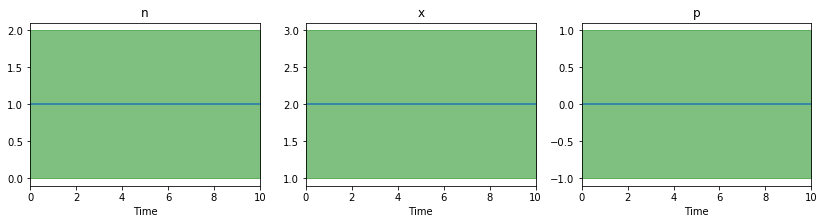

In [203]:


plot_expect_with_variance(N, [n, x, p], [r'n', r'x', r'p'], result.states);



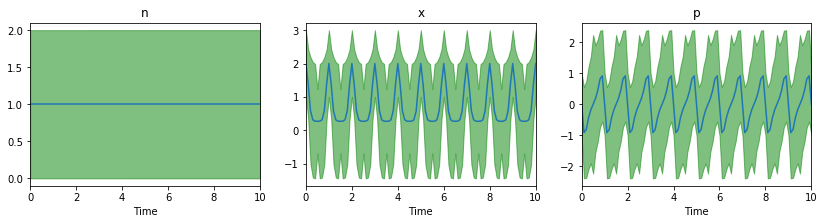

In [204]:
plot_expect_with_variance(N, [n, x, p], [r'n', r'x', r'p'], result2.states);

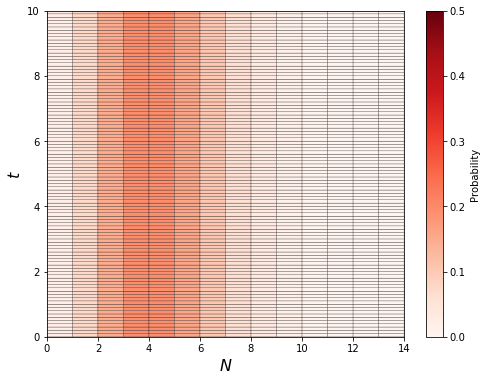

In [165]:


plot_fock_distribution_vs_time(tlist, result.states);



In [77]:


from matplotlib import animation
from IPython.display import HTML
from numpy import *

RuntimeError: The animation function must return a sequence of Artist objects.

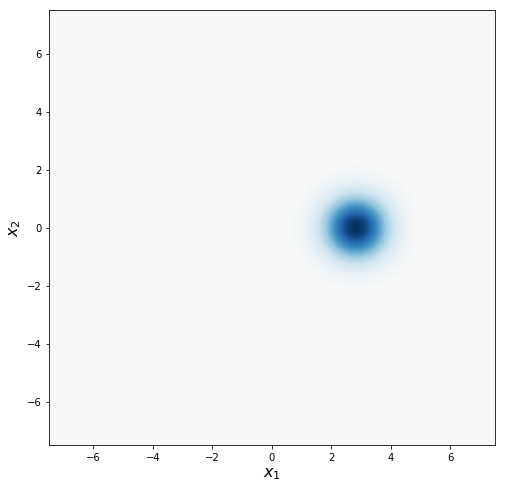

In [78]:


fig, ax = plt.subplots(1, 1, figsize=(8,8))

def update(n): 
    plot_wigner(result.states[n], fig=fig, ax=ax)

anim = animation.FuncAnimation(fig, update, frames=len(result.states), blit=True)

anim.save('animation-kerr-coherent-state.mp4', fps=10, writer="avconv", codec="libx264")
#anim.save('animation-kerr-coherent-state.gif', writer='imagemagick', fps=10)

plt.close(fig)



In [79]:
display_embedded_video("animation-kerr-coherent-state.mp4")

IOError: [Errno 2] No such file or directory: 'animation-kerr-coherent-state.mp4'

In [80]:
psi = (exp(1j*pi/4) * coherent(N, -2.0j) + exp(-1j*pi/4) * coherent(N, 2.0j)).unit()

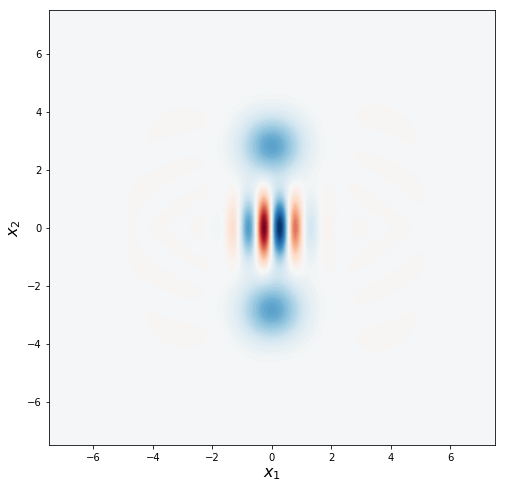

In [81]:
plot_wigner(psi);